In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F
import torchvision.models as models
from torch.utils.data import Dataset,DataLoader, ConcatDataset
from tqdm import tqdm
import torchmetrics
from collections import Counter
import torchvision.datasets as datasets
from sklearn.metrics import classification_report, roc_auc_score, roc_curve
import pandas as pd
import optuna
from optuna.trial import TrialState
import os
import pickle
from sklearn.metrics import RocCurveDisplay
from sklearn.model_selection import RandomizedSearchCV

/home/uottawa.o.univ/sadin008/myenv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device= torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

In [4]:
transform = transforms.Compose([
    #transforms.RandomResizedCrop(size=(256, 256), antialias=True),
    transforms.Resize((256, 256)), # Resize all images to a uniform size (e.g., 64x64 pixels)
    transforms.ToTensor(), # Convert PIL Image to PyTorch tensor (0-255 to 0.0-1.0)
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)), # Normalize pixel values
    transforms.RandomHorizontalFlip(p=0.5)
    
])

In [5]:


train_dir = 'real-vs-fake/train' 
test_dir = 'real-vs-fake/test' 
val_dir = 'real-vs-fake/val' 

train_dataset=torchvision.datasets.ImageFolder(root=train_dir, transform=transform)
test_dataset=torchvision.datasets.ImageFolder(root=test_dir, transform=transform)
val_dataset=torchvision.datasets.ImageFolder(root=val_dir, transform=transform)




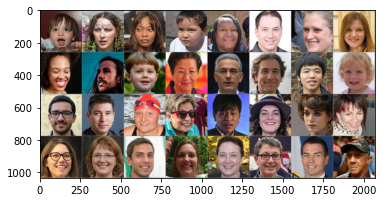

In [6]:
batch_size = 32
train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True, # Shuffle data for training
    num_workers=2 # Use multiple subprocesses for data loading 
)

# get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images))

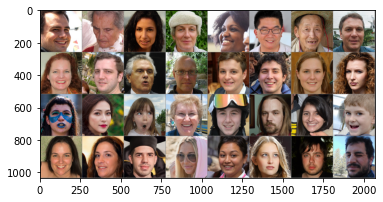

In [7]:

test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=True, # Shuffle data for training
    num_workers=2 # Use multiple subprocesses for data loading 
)

# get some random training images
dataiter = iter(test_loader)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images))

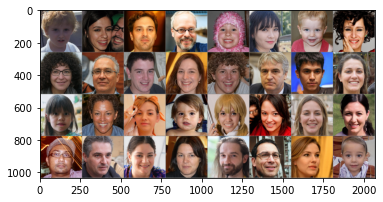

In [8]:

val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=True, # Shuffle data for training
    num_workers=2 # Use multiple subprocesses for data loading 
)

# get some random training images
dataiter = iter(test_loader)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


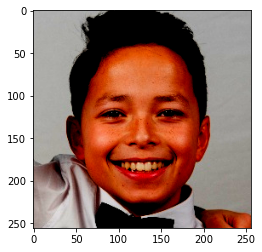

torch.Size([3, 256, 256])

In [9]:
#Sanity check (set shuffle=False in loader so order in file explorer is perserved)
index=0
npimg=train_loader.dataset[index][0].numpy()
plt.imshow(np.transpose(npimg, (1, 2, 0)))
plt.show()
train_loader.dataset[index][1]

img, label=train_loader.dataset[index]
img.size()


In [10]:
# Calculate the class distribution
train_distribution = Counter(train_dataset.targets)
print(f"Train distribution: {train_distribution}")

# Calculate the class distribution
val_distribution = Counter(val_dataset.targets)
print(f"Validation distribution: {val_distribution}")

# Calculate the class distribution
test_distribution = Counter(test_dataset.targets)
print(f"Test distribution: {test_distribution}")



Train distribution: Counter({0: 8620, 1: 7565})
Validation distribution: Counter({1: 2694, 0: 2655})
Test distribution: Counter({0: 3143, 1: 3048})


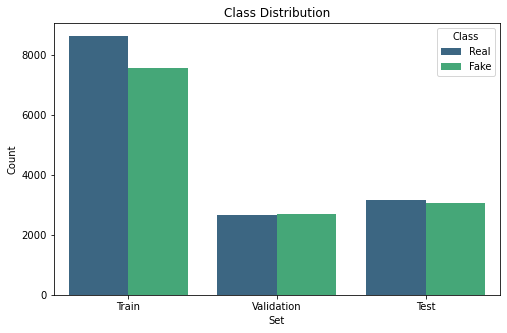

In [11]:
#https://www.kaggle.com/code/skshitij/deepfake-detection
data_counts = {
    'Set': ['Train', 'Train', 'Validation', 'Validation', 'Test', 'Test'],
    'Class': ['Real', 'Fake', 'Real', 'Fake', 'Real', 'Fake'],
    'Count': [train_distribution[0], train_distribution[1],
              val_distribution[0], val_distribution[1],
              test_distribution[0], test_distribution[1]]
}

df_counts = pd.DataFrame(data_counts)

plt.figure(figsize=(8,5))
sns.barplot(x="Set", y="Count", hue="Class", data=df_counts, palette="viridis")
plt.title("Class Distribution")
plt.show()


<h2>CNN</h2>

In [12]:
class CNN(nn.Module):
   def __init__(self, in_channels, num_classes, l1=256):

       """
       Building blocks of convolutional neural network.

       Parameters:
           * in_channels: Number of channels in the input image (for grayscale images, 1)
           * num_classes: Number of classes to predict. In our problem, 10 (i.e digits from  0 to 9).
       """
       super(CNN, self).__init__()

       # dropout layer
       self.dropout1 = nn.Dropout(0.2)
       # 1st convolutional layer
       self.conv1 = nn.Conv2d(in_channels=in_channels, out_channels=8, kernel_size=3, padding=1)
       # Max pooling layer
       self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
       # 2nd convolutional layer
       self.conv2 = nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, padding=1)
       # 2nd convolutional layer
       self.conv3 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
       # Fully connected layers
       self.fc1 = nn.Linear(32 * 32 * 32, l1)
       self.fc2 = nn.Linear(l1, num_classes)

   def forward(self, x):
       """
       Define the forward pass of the neural network.

       Parameters:
           x: Input tensor.

       Returns:
           torch.Tensor
               The output tensor after passing through the network.
       """
       x = F.relu(self.conv1(x))  # Apply first convolution and ReLU activation
       x = self.pool(x)           # Apply max pooling
       x = F.relu(self.conv2(x))  # Apply second convolution and ReLU activation
       x = self.pool(x)           # Apply max pooling
       x = F.relu(self.conv3(x))  # Apply second convolution and ReLU activation
       x = self.dropout1(x)       # dropout
       x = self.pool(x)           # Apply max pooling
       x = x.reshape(x.shape[0], -1)  # Flatten the tensor
       x = self.fc1(x)            # Apply fully connected layer
       x = self.fc2(x)            # Apply fully connected layer
       return x
    


In [13]:

def baseline_cnn():
    # Generate the model.
    model = CNN(in_channels=3, num_classes=1).to(device)
    
    # Define the loss function
    criterion = nn.BCEWithLogitsLoss() 
    
    # Generate the optimizers.

    optimizer = optim.Adam(model.parameters())

    # Training of the model.
    num_epochs=10

    train_loss_plots=np.zeros(num_epochs) # for visualization plots
    val_loss_plots=np.zeros(num_epochs) # for visualization plots

    for epoch in range(num_epochs):
    # Iterate over training batches
        print(f"Epoch [{epoch + 1}/{num_epochs}]")
        
        running_loss=0.0
        for batch_index, (data, targets) in enumerate(tqdm(train_loader)):
            targets = targets.float().view(-1, 1)
            data = data.to(device)
            targets = targets.to(device)
            scores = model(data)
            loss = criterion(scores, targets)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            running_loss+=loss.item()
        epoch_train_loss=running_loss/len(train_loader)
        train_loss_plots[epoch]=epoch_train_loss
        
        acc = torchmetrics.Accuracy(task="binary").to(device)
        acc.reset()
        valid_loss = 0.0
        correct=0.0
        total=0.0
        model.eval()     
        for batch_index, (data, targets) in enumerate(tqdm(val_loader)):
            targets = targets.float().view(-1, 1)
            data = data.to(device)
            targets = targets.to(device)
            scores = model(data)


            probabilities = torch.sigmoid(scores)
            predicted_classes = (probabilities > 0.5).float()
            
            total += targets.size(0)
            correct += (predicted_classes == targets).sum().item()
            
            loss = criterion(scores, targets)
            valid_loss += loss.item()
            
        epoch_valid_loss=valid_loss/len(val_loader)
        val_loss_plots[epoch]=epoch_valid_loss
        
        print(f'Epoch {epoch+1} Results[ Training Loss: {epoch_train_loss}, Validation Loss: {epoch_valid_loss} ]')
        print('---------------------------------------------')

        accuracy = correct / total
#baseline_cnn()

<h3>Objective Function(Training)</h3>

In [14]:
base_path = "./artifacts"
os.makedirs(base_path, exist_ok=True)
artifact_store = optuna.artifacts.FileSystemArtifactStore(base_path=base_path)
def objective(trial):
    
    # Generate the model.
    model = CNN(in_channels=3, num_classes=1).to(device)
    
    # Define the loss function
    criterion = nn.BCEWithLogitsLoss() 
    
    # Generate the optimizers.
    lr = trial.suggest_float("lr", 1e-5, 1e-1, log=True)
    decay = trial.suggest_float("weight_decay", 1e-5, 1e-1, log=True)
    optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=decay)

    # Training of the model.
    num_epochs=10

    train_loss_plots=np.zeros(num_epochs) # for visualization plots
    val_loss_plots=np.zeros(num_epochs) # for visualization plots

    for epoch in range(num_epochs):
    # Iterate over training batches
        print(f"Epoch [{epoch + 1}/{num_epochs}]")

        # TRAINING
        running_loss=0.0
        for batch_index, (data, targets) in enumerate(tqdm(train_loader)):
            targets = targets.float().view(-1, 1)
            data = data.to(device)
            targets = targets.to(device)
            scores = model(data)
            loss = criterion(scores, targets)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            running_loss+=loss.item()
        epoch_train_loss=running_loss/len(train_loader)
        train_loss_plots[epoch]=epoch_train_loss

        # VALIDATION
        valid_loss = 0.0
        correct=0.0
        total=0.0
        model.eval()     
        for batch_index, (data, targets) in enumerate(tqdm(val_loader)):
            targets = targets.float().view(-1, 1)
            data = data.to(device)
            targets = targets.to(device)
            scores = model(data)


            probabilities = torch.sigmoid(scores)
            predicted_classes = (probabilities > 0.5).float()
            
            total += targets.size(0)
            correct += (predicted_classes == targets).sum().item()
            
            loss = criterion(scores, targets)
            valid_loss += loss.item()
            
        epoch_valid_loss=valid_loss/len(val_loader)
        val_loss_plots[epoch]=epoch_valid_loss
        
        print(f'Epoch {epoch+1} Results[ Training Loss: {epoch_train_loss}, Validation Loss: {epoch_valid_loss} ]')
        print('---------------------------------------------')

        accuracy = correct / total
        trial.report(accuracy, epoch)

        # Handle pruning based on the intermediate value.
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()

    
    # Save the model using ArtifactStore
    with open("model.pickle", "wb") as fout:
        pickle.dump(model, fout)
    artifact_id = optuna.artifacts.upload_artifact(
        artifact_store=artifact_store,
        file_path="model.pickle",
        study_or_trial=trial.study,
    )
    trial.set_user_attr("artifact_id", artifact_id)
    
    # Store training/validation loss for plots
    trial.set_user_attr("train_loss", train_loss_plots)
    trial.set_user_attr("val_loss", val_loss_plots)
    
    
    return accuracy


<h3>Hyperparameter Tuning</h3>

In [15]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=10)



[I 2025-12-03 02:10:39,040] A new study created in memory with name: no-name-af777c13-6ce7-470f-965d-6195d685e294


Epoch [1/10]


100%|██████████| 168/168 [00:08<00:00, 18.84it/s]


Epoch 1 Results[ Training Loss: 0.6888550125327506, Validation Loss: 0.6918626860493705 ]
---------------------------------------------
Epoch [2/10]


100%|██████████| 168/168 [00:08<00:00, 19.45it/s]


Epoch 2 Results[ Training Loss: 0.6856976979570426, Validation Loss: 0.6904078076283137 ]
---------------------------------------------
Epoch [3/10]


100%|██████████| 168/168 [00:08<00:00, 19.30it/s]


Epoch 3 Results[ Training Loss: 0.680564006797881, Validation Loss: 0.683797602497396 ]
---------------------------------------------
Epoch [4/10]


 63%|██████▎   | 320/506 [00:18<00:10, 17.44it/s]
[W 2025-12-03 02:12:49,738] Trial 0 failed with parameters: {'lr': 0.0016225543825193487, 'weight_decay': 0.01748477520558446} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "/home/uottawa.o.univ/sadin008/myenv/lib/python3.10/site-packages/optuna/study/_optimize.py", line 205, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_2318466/3891848654.py", line 30, in objective
    targets = targets.float().view(-1, 1)
KeyboardInterrupt
[W 2025-12-03 02:12:49,740] Trial 0 failed with value None.


KeyboardInterrupt: 

In [ ]:
pruned_trials = study.get_trials(deepcopy=False, states=[TrialState.PRUNED])
complete_trials = study.get_trials(deepcopy=False, states=[TrialState.COMPLETE])

print("Study statistics: ")
print("  Number of finished trials: ", len(study.trials))
print("  Number of pruned trials: ", len(pruned_trials))
print("  Number of complete trials: ", len(complete_trials))

print("Best trial:")
trial = study.best_trial

print("  Value: ", trial.value)

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

In [ ]:
#Save the best model from the ae
best_artifact_id = trial.user_attrs["artifact_id"]
best_model_path=f"model_{best_artifact_id}.pickle"
optuna.artifacts.download_artifact(
    artifact_store=artifact_store,
    file_path=best_model_path,
    artifact_id=best_artifact_id,
)

In [ ]:
# Load tuned model
best_model = CNN(in_channels=3, num_classes=2)
with open(best_model_path, 'rb') as file:  
    best_model = pickle.load(file)

<h3>Evaluation</h3>

In [ ]:
# Accuracy metric
acc = torchmetrics.Accuracy(task="binary").to(device)

# Iterate over the dataset batches
acc.reset()
best_model.eval()
probabilities=[]
y_pred_cnn=[]
y_true_cnn=[]
correct=0.0
total=0.0
with torch.no_grad():
   for images, labels in test_loader:
        y_true_cnn.extend(labels)
        # Get predicted probabilities for test data batch
        
        labels = labels.float().view(-1, 1)
        images, labels = images.to(device), labels.to(device)
        outputs = best_model(images)

        probs = torch.sigmoid(outputs)
        predicted_classes = (probs > 0.5).float()
        probabilities.extend(probs)
        
        total += labels.size(0)
        correct += (predicted_classes == labels).sum().item()
        #probabilities.extend(outputs[:,1])
        #_, preds = torch.max(outputs, 1)
        acc.update(outputs, labels)
        y_pred_cnn.extend(predicted_classes)
        
        

#Compute total test accuracy
test_accuracy = acc.compute()
print(f"Test accuracy: {test_accuracy}")

<h3>CNN Results Visualization</h3>

In [ ]:
# Moving variables to cpu
preds=torch.tensor(y_pred_cnn).cpu()
trues=torch.tensor(y_true_cnn).cpu()
probs=torch.tensor(probabilities).cpu()

In [ ]:
#Classification report
print(classification_report(trues, preds))

In [ ]:
#ROC curves
fpr, tpr, thresholds = roc_curve(trues, probs)
roc_auc = roc_auc_score(trues, probs)

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label='AUC = %0.3f' % roc_auc)
plt.plot([0,1],[0,1], '--', color="gray")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Baseline CNN')
plt.legend(loc='lower right')
plt.show()


In [ ]:
#Validation vs Training Loss
plt.plot(trial.user_attrs['train_loss'], label='Train Loss')
plt.plot(trial.user_attrs['val_loss'], label='Val Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss of Best Model")
plt.legend()
plt.show()

<h2> VGG Model </h2>

<h3>Training</h3>

In [ ]:
# --- Configuring the VGG Model for Binary Classification ---
# (num of output classes for binary classification is 1)
num_classes = 1

# Load a pre-trained VGG16 model with default weights
vgg_model = models.vgg16(weights=models.VGG16_Weights.DEFAULT)

# Modify the final fully connected layer to match the single output class
num_features = vgg_model.classifier[-1].in_features
vgg_model.classifier[-1] = nn.Linear(num_features, num_classes)

# Move the model to GPU if available
vgg_model.to(device)

print(f"VGG model configured for binary classification, running on {device}")

# --- Define Loss Function and Optimizer for Binary Classification ---

criterion = nn.BCEWithLogitsLoss() # use for "numerical stability"
optimizer = optim.SGD(vgg_model.parameters(), lr=0.001, momentum=0.9)

# --- The Training Loop!!! ---
NUM_EPOCHS = 3
train_loss_plots=np.zeros(NUM_EPOCHS) # for visualization plots
val_loss_plots=np.zeros(NUM_EPOCHS) # for visualization plots

print("Starting Training...")
for epoch in range(NUM_EPOCHS):
    vgg_model.train() # Set model to training mode
    running_loss = 0.0
    
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        
        # Ensure labels are type float and have shape [batch_size, 1]
        labels = labels.float().view(-1, 1)
        
        inputs, labels = inputs.to(device), labels.to(device)

        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass: Plug inputs into the VGG model
        outputs = vgg_model(inputs)
        
        # Calculate loss using the binary criteria
        loss = criterion(outputs, labels)

        # Backward pass +optimize
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    
    epoch_train_loss=running_loss/len(train_loader)
    train_loss_plots[epoch]=epoch_train_loss
     
    #--- Validation ---
    valid_loss = 0.0
    correct=0.0
    total=0.0
    vgg_model.eval()     
    for batch_index, (data, targets) in enumerate(tqdm(val_loader)):
        targets = targets.float().view(-1, 1)
        data = data.to(device)
        targets = targets.to(device)
        scores = vgg_model(data)


        probabilities = torch.sigmoid(scores)
        predicted_classes = (probabilities > 0.5).float()
        
        total += targets.size(0)
        correct += (predicted_classes == targets).sum().item()
        
        loss = criterion(scores, targets)
        valid_loss += loss.item()
        
    epoch_valid_loss=valid_loss/len(val_loader)
    val_loss_plots[epoch]=epoch_valid_loss
    
    print(f'Epoch {epoch+1} Results[ Training Loss: {epoch_train_loss}, Validation Loss: {epoch_valid_loss} ]')
    print('---------------------------------------------')
#print(f"--- Epoch {epoch+1} finished. Avg Loss: {running_loss/len(train_loader):.3f} ---")

print('Training complete.')


<h3>Evaluation</h3>

In [ ]:
# --- Making Predictions ---

vgg_model.eval() # Set model to evaluation mode
vgg_probabilities=[]
y_pred_vgg=[]
y_true_vgg=[]
correct = 0
total = 0
with torch.no_grad():
    for data in test_loader:
        inputs, labels = data
        y_true_vgg.extend(labels) # Add groundtruth to labels list
        labels = labels.float().view(-1, 1) # Reshape for consistency
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = vgg_model(inputs)
        probabilities = torch.sigmoid(outputs)
        predicted_classes = (probabilities > 0.5).float()
        vgg_probabilities.extend(probabilities) # Add probabilities to probabilities list
        
        total += labels.size(0)
        correct += (predicted_classes == labels).sum().item()
        
        y_pred_vgg.extend(predicted_classes)


print(f"\nAccuracy on the test set: {100 * correct / total:.2f}%")



<h3>VGG Results Visualization</h3>

In [ ]:
# Moving variables to cpu
preds=torch.tensor(y_pred_vgg).cpu()
trues=torch.tensor(y_true_vgg).cpu()
probs=torch.tensor(vgg_probabilities).cpu()

In [ ]:
#Classification report
print(classification_report(trues, preds))

In [ ]:
#ROC curves
fpr, tpr, thresholds = roc_curve(trues, probs)
roc_auc = roc_auc_score(trues, probs)

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label='AUC = %0.3f' % roc_auc)
plt.plot([0,1],[0,1], '--', color="gray")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Baseline CNN')
plt.legend(loc='lower right')
plt.show()


In [ ]:
#Validation vs Training Loss
plt.plot(train_loss_plots, label='Train Loss')
plt.plot(val_loss_plots, label='Val Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss of VGG")
plt.legend()
plt.show()

<h2> FEATURE EXTRACTION FUNCTION </h2>

In [18]:

# function to extract features 
def extract_features(data_loader):
    #iterates through DataLoader and flattens image tensors
    all_features = []
    all_labels = []

    for images, labels in data_loader:
        # flatten the image data: C * H * W
        # resulting shape: (Batch, Features)
        flattened_images = images.reshape(images.shape[0], -1)

        # convert to numpy and append
        all_features.append(flattened_images.numpy())
        all_labels.append(labels.numpy())

    # concatenates all batches into single numpy arrays
    X = np.concatenate(all_features, axis=0)
    y = np.concatenate(all_labels, axis=0)
    
    return X, y

<h1> SDT DATA PROCESSING <h/1>

<!-- <h2> GB </h2> -->

In [ ]:
print("Processing Training Data...")
train_val_dataset = ConcatDataset([train_dataset, val_dataset])
train_val_loader = DataLoader(train_val_dataset, batch_size=64, shuffle=True)


X_train, y_train = extract_features(train_val_loader)

print("Processing Testing Data...")
X_test, y_test = extract_features(test_loader)

print(f"\nFinal X_train shape: {X_train.shape}")
print(f"Final X_test shape: {X_test.shape}")

Processing Training Data...
Processing Testing Data...

Final X_train shape for GB: (21534, 196608)
Final X_test shape for GB: (6191, 196608)


<h1> SINGLE DECISION TREE </h1>

SINGLE DECISION TREE
              precision    recall  f1-score   support

           0       0.64      0.64      0.64      3143
           1       0.63      0.63      0.63      3048

    accuracy                           0.64      6191
   macro avg       0.64      0.64      0.64      6191
weighted avg       0.64      0.64      0.64      6191



AttributeError: type object 'RocCurveDisplay' has no attribute 'from_estimator'

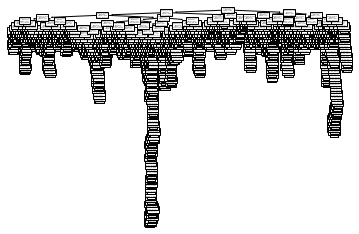

In [ ]:
from sklearn import tree
dt = tree.DecisionTreeClassifier()
dt = dt.fit(X_train,y_train)

y_predictions=dt.predict(X_test)

print("SINGLE DECISION TREE")
print(classification_report(y_test,y_predictions))

#tree.plot_tree(dt)

In [24]:
ytree_prob_base = dt.predict_proba(X_test)[:, 1]

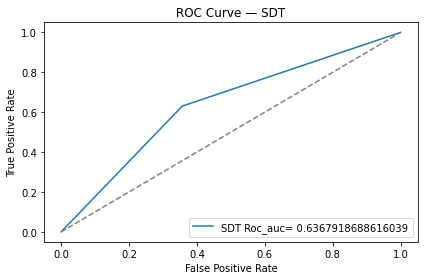

In [28]:
fpr, tpr, _= roc_curve(y_test, ytree_prob_base)     
plt.plot(fpr, tpr, label="{0} Roc_auc= {1}".format("SDT", roc_auc_score(y_test, ytree_prob_base)))
plt.legend(loc="lower right")
    
    

plt.plot([0,1], [0,1], "--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve — SDT")
plt.legend(loc="lower right")
plt.tight_layout()

In [ ]:
param_dist = {
'splitter': ['best', 'random'],
'max_depth' : [5, 50, 500],
"min_samples_split": [2, 50, 100]
}

random_search = RandomizedSearchCV(dt, param_dist,  n_iter=10, cv=5, return_train_score=True)
random_search.fit(X_train, y_train)


print("Best parameters (RandomizedSearchCV):", random_search.best_params_)

In [ ]:
tree_predict = random_search.predict(X_test)
ytree_prob = random_search.predict_proba(X_test)[:, 1]